# Ablation Study
## Residual connection
### CIFAR-10

In [1]:
#!pip install tensorflow-datasets

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_pregress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스 바가 나타나지 않습니다

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
# tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확ㅇ니하세요
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [6]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### Input Normalization

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_info.features['label'].num_classes

10

In [10]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

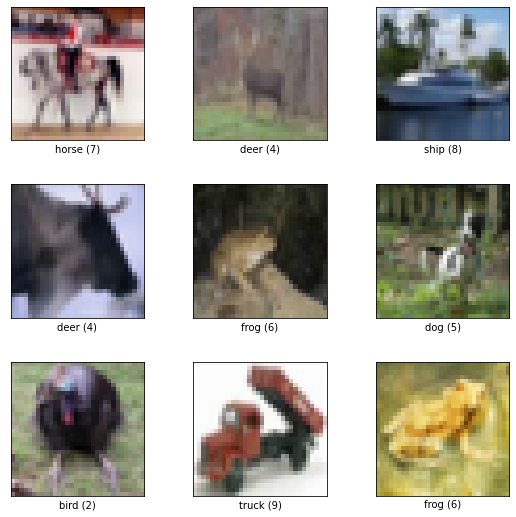

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

## 블록 구성하기
딥러닝 모델의 주요 구조를 모듈화시켜 사용하는 단위\
레이어 + 레이어 + ... = 블록 block

---
## VGG
### 기본 블록 만들기
VGG-16, VGG-19

In [12]:
def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1,
                   ):
    # input layer
    x = input_layer
    
    # CNN layer
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        
    # Max Pooling layer
    x = keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)
    
    return x

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))
vgg_block_output = build_vgg_block(vgg_input_layer)

In [14]:
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


### VGG-16

In [15]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
def build_resnet(input_shape=(32,32,3),
                num_cnn_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                is_50=False):
    # assert 조건문 : 조건이 False일 경우 asserterror 반환
    assert len(num_cnn_list) == len(channel_list)   #모델의 구조에 맞춰 config list 들이 같은 길이인지 확인합니다
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
   
    # 1st Conv layer
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i
        )
    
    output = keras.layers.Flatten()

In [17]:
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### VGG-19

In [18]:
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## VGG-16 vs VGG-19

In [19]:
BATCH_SIZE = 256
EPOCH = 20

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train','test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
    
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 107s 389ms/step - loss: 2.2325 - accuracy: 0.1607 - val_loss: 2.0324 - val_accuracy: 0.2515
Epoch 2/20
195/195 [==============================] - 50s 259ms/step - loss: 2.0111 - accuracy: 0.2735 - val_loss: 1.9054 - val_accuracy: 0.3232
Epoch 3/20
102/195 [==============>...............] - ETA: 19s - loss: 1.8663 - accuracy: 0.3316

KeyboardInterrupt: 

In [22]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
 10/195 [>.............................] - ETA: 47s - loss: 2.3020 - accuracy: 0.1007

KeyboardInterrupt: 

In [23]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

NameError: name 'history_16' is not defined

In [27]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

NameError: name 'history_16' is not defined

---
## ResNet 구현하기
### ResNet-34 VS ResNet-50
* Skip connection(or shortcut) 을 갖는 ResNet의 Identity block을 먼저 구성한다 -> 블록을 쌓아 전체 구조를 완성

* ResNet-34 는 7단의 레이어 -> ResNet-50 은 3단이 추가되어 10단 레이어로 기본 구성된다

* concatenate 과정에서 출력값과 채널수가 다른 문제를 해결하기 위해, shortcut 에 Conv2D + BN 레이어를 추가한다.

In [28]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

In [29]:
def identity_block(X, f, filters, stage, block):
    '''
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape(m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value, You'll need this later to add block to the main path
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(F1, kernel_size=(1,1), strides=(1,1), 
               padding='valid', 
               name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed=0)
              )(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (=3 lines)
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1),
              padding='same',
              name=conv_name_base + '2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (=2 lines)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1),
              padding='valid',
              name=conv_name_base + '2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    
    # Final step: Add shortcut value to main path, and pass it through a ReLU activation (=2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

ValueError: Operands could not be broadcast together with shapes (32, 32, 256) (32, 32, 3)

* -> Shortcut과 출력값간의 채널 크기가 맞지않기 때문에 Conv2D + BN 추가

In [30]:
def convolutional_block(X, f, filters, stage, block, s=2, is_50=False):
    '''
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape(m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value, You'll need this later to add block to the main path
    X_shortcut = X
    
    
    ### MAIN PATH ###
    # First component of main path
    X = Conv2D(F1, kernel_size=(1,1), strides=(s,s), 
               padding='valid', 
               name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed=0)
              )(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (=3 lines)
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1),
              padding='same',
              name=conv_name_base + '2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (=2 lines)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1),
              padding='valid',
              name=conv_name_base + '2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    
    ### SHORTCUT PATH ###
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s),
                        padding='valid',
                        name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0)
                       )(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name = bn_name_base + '1')(X_shortcut)

    
    # Final step: Add shortcut value to main path, and pass it through a ReLU activation (=2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

* 블록 구성을 확인하기위한 입-출력 설정 -> `model.summary()`

In [31]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))
resnet_block_output = convolutional_block(X=resnet_input_layer, f=3, filters=[64,64,256],  stage='34', block='1')

In [32]:
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
res341_branch2a (Conv2D)        (None, 16, 16, 64)   256         input_4[0][0]                    
__________________________________________________________________________________________________
bn341_branch2a (BatchNormalizat (None, 16, 16, 64)   256         res341_branch2a[0][0]            
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           bn341_branch2a[0][0]             
____________________________________________________________________________________________

### Skip connection 을 갖는 ResNet-34, ResNet-50 클래스 구현
* `resnet34_skip_block`, `resnet50_skip_block`
* `resnet34_plain_block`, `resnet50_plain_block`

In [35]:
def resnet34_conv_block(X, f, filters, stage, block, s=2):
    '''
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape(m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value, You'll need this later to add block to the main path
    X_shortcut = X
    
    ### MAIN PATH ###
    # First component of main path
    X = Conv2D(F1, kernel_size=(1,1), strides=(s,s), 
               padding='valid', 
               name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed=0)
              )(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (=3 lines)
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1),
              padding='same',
              name=conv_name_base + '2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (=2 lines)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1),
              padding='valid',
              name=conv_name_base + '2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    
    ### SHORTCUT PATH ###
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s),
                        padding='valid',
                        name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0)
                       )(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name = bn_name_base + '1')(X_shortcut)

    
    # Final step: Add shortcut value to main path, and pass it through a ReLU activation (=2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [37]:
def resnet50_conv_block(X, f, filters, stage, block, s=2):
    '''
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape(m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    '''
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value, You'll need this later to add block to the main path
    X_shortcut = X
    
    ### MAIN PATH ###
    # First component of main path
    X = Conv2D(F1, kernel_size=(1,1), strides=(s,s), 
               padding='valid', 
               name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed=0)
              )(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (=3 lines)
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1),
              padding='same',
              name=conv_name_base + '2b',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (=2 lines)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1),
              padding='valid',
              name=conv_name_base + '2c',
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    
    ### SHORTCUT PATH ###
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s),
                        padding='valid',
                        name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0)
                       )(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name = bn_name_base + '1')(X_shortcut)

    
    # Final step: Add shortcut value to main path, and pass it through a ReLU activation (=2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

### ResNet 객체화를 위한 클래스 함수 구현

In [75]:
class IdentityBlock_34(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock_34, self).__init__(name='')
        
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.bn2 = BatchNormalization()
        
        # skip_connect with conv layer to match dimension
        self.conv_skip = Conv2D(filters, kernel_size=(1,1), padding='valid')
        self.bn_skip = BatchNormalization()        
        
        self.relu = Activation('relu')
        self.add = Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        inputs = self.conv_skip(inputs)
        inputs = self.bn_skip(inputs)
        
        x = self.add([x, inputs])
        x = self.relu(x)
        
        return x

In [76]:
class IdentityBlock_50(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock_50, self).__init__(name='')
        
        self.conv1 = Conv2D(filters, kernel_size=(1,1))
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(filters, kernel_size=(3,3), padding='same')
        self.bn2 = BatchNormalization()
        
        self.conv3 = Conv2D(filters*4, kernel_size=(1,1), padding='valid')
        self.bn3 = BatchNormalization()

        # skip_connect with conv layer to match dimension
        self.conv_skip = Conv2D(filters*4, kernel_size=(1,1), padding='valid')
        self.bn_skip = BatchNormalization()
        
        self.relu = Activation('relu')
        self.add = Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        # skip_connect with conv layer to match dimension
        inputs = self.conv_skip(inputs)
        inputs = self.bn_skip(inputs)
        
        x = self.add([x, inputs])
        x = self.relu(x)
        
        return x

In [77]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes, is_50=False):
        super(ResNet, self).__init__()
        self.conv = Conv2D(64, 7, strides=(2,2), padding='same')
        self.bn = BatchNormalization()
        self.relu = Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3,3))

        if not is_50:   # ResNet-34
            self.id1a = IdentityBlock_34(64,3)
            self.id1b = IdentityBlock_34(128,4)
            self.id1c = IdentityBlock_34(256,6)
            self.id1d = IdentityBlock_34(512,3)
            
        else:   # ResNet-50
            self.id1a = IdentityBlock_50(64,3)
            self.id1b = IdentityBlock_50(128,4)
            self.id1c = IdentityBlock_50(256,6)
            self.id1d = IdentityBlock_50(512,3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.max_pool(x)
        
        x = self.id1a(x)
        x = self.id1b(x)
        x = self.id1c(x)
        x = self.id1d(x)
        
        x = self.global_pool(x)
        return self.classifier(x)

In [73]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train[:,:,:, tf.newaxis]
x_test = x_test[:,:,:,tf.newaxis]

In [78]:
resnet34_skip = ResNet(10)
resnet34_skip.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['acc'])
resnet34_skip.fit(x_train, y_train, epochs=1)
resnet34_skip.evaluate(x_test, y_test)

313/313 [==============================] - 8s 24ms/step - loss: 0.0865 - acc: 0.9746


[0.08647561818361282, 0.9746000170707703]

In [79]:
resnet50_skip = ResNet(10, is_50=True)
resnet50_skip.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['acc'])
resnet50_skip.fit(x_train, y_train, epochs=1)
resnet50_skip.evaluate(x_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 0.1312 - acc: 0.9645


[0.13123776018619537, 0.9645000100135803]

In [87]:
class IdentityBlock_34_plain(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock_34_plain, self).__init__(name='')
        
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.bn2 = BatchNormalization()
                
        self.relu = Activation('relu')
        self.add = Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        x = self.relu(x)
        
        return x

In [88]:
class IdentityBlock_50_plain(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock_50_plain, self).__init__(name='')
        
        self.conv1 = Conv2D(filters, kernel_size=(1,1))
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(filters, kernel_size=(3,3), padding='same')
        self.bn2 = BatchNormalization()
        
        self.conv3 = Conv2D(filters*4, kernel_size=(1,1), padding='valid')
        self.bn3 = BatchNormalization()
        
        self.relu = Activation('relu')
        self.add = Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)

        x = self.relu(x)
        
        return x

In [89]:
class ResNet_plain(tf.keras.Model):
    def __init__(self, num_classes, is_50=False):
        super(ResNet_plain, self).__init__()
        self.conv = Conv2D(64, 7, strides=(2,2), padding='same')
        self.bn = BatchNormalization()
        self.relu = Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3,3))

        if not is_50:   # ResNet-34-plain
            self.id1a = IdentityBlock_34_plain(64,3)
            self.id1b = IdentityBlock_34_plain(128,4)
            self.id1c = IdentityBlock_34_plain(256,6)
            self.id1d = IdentityBlock_34_plain(512,3)
            
        else:   # ResNet-50-plain
            self.id1a = IdentityBlock_50_plain(64,3)
            self.id1b = IdentityBlock_50_plain(128,4)
            self.id1c = IdentityBlock_50_plain(256,6)
            self.id1d = IdentityBlock_50_plain(512,3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.max_pool(x)
        
        x = self.id1a(x)
        x = self.id1b(x)
        x = self.id1c(x)
        x = self.id1d(x)
        
        x = self.global_pool(x)
        return self.classifier(x)

In [91]:
resnet34_plain = ResNet_plain(10, is_50=False)
resnet34_plain.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['acc'])
resnet34_plain.fit(x_train, y_train, epochs=1)
resnet34_plain.evaluate(x_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 0.1102 - acc: 0.9658


[0.1102064698934555, 0.9657999873161316]

In [92]:
resnet50_plain = ResNet_plain(10, is_50=True)
resnet50_plain.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['acc'])
resnet50_plain.fit(x_train, y_train, epochs=1)
resnet50_plain.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0587 - acc: 0.9839


[0.05867284536361694, 0.9839000105857849]